# 🛠️ Data Preprocessing

## 🎯 Objective

The goal of this step is to clean and standardize the dataset to ensure high-quality input for model training.

## ⚠️ Handling Missing Values

In file `1_data-collection.ipynb`, we checked the missing values (that we assume that each image must have at least 3 captions) and we did not find any missing value and realized that all images having all 5 captions $\implies$ **SKIP**

## 📝 Captions Tokenization
I used GG Colab to easily implement approach [`vncorenlp`](https://github.com/vncorenlp/VnCoreNLP) module

**Prerequisites:**
- Java 1.8+ (Prerequisite)
- File VnCoreNLP-1.2.jar (27MB) and folder models (115MB) are placed in the same working folder.
- Python 3.6+ if using a Python wrapper of VnCoreNLP.

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=a879b795c7c173caabe1aeb41d88b18eb66c410fa8de01b4f1c1d118d2c229b6
  Stored in directory: /root/.cache/pip/wheels/80/ad/d4/9e1a0939f63331a3898f2a951a368bbf0d69f7b027cae4d66b
Successfully built vncorenlp


In [3]:
import re
import unicodedata
import os
import json
import pickle
import pandas as pd
from collections import Counter
from tqdm import tqdm
from vncorenlp import VnCoreNLP

In [4]:
path = "/content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/vncorenlp/VnCoreNLP-1.2.jar"

print("Khởi tạo VnCoreNLP...")
vncorenlp = VnCoreNLP(path, annotators="wseg", max_heap_size='-Xmx2g')
print("Khởi tạo VnCoreNLP thành công")

Khởi tạo VnCoreNLP...
Khởi tạo VnCoreNLP thành công


In [5]:
captions_path = "/content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/captions.txt"

df = pd.read_csv(captions_path, sep='\t', names=['image_filename', 'caption'], encoding='utf-8')
print(f"Đã đọc {len(df)} captions")

Đã đọc 9020 captions


In [6]:
df.head()

image_filename                                            caption
0  archery_0.jpg  Vận động viên nữ giương cung nhắm chuẩn vào bi...
1  archery_0.jpg  Tay cung giữ tư thế ổn định, ánh mắt tập trung...
2  archery_0.jpg  Người chơi bắn cung sử dụng cung tiêu chuẩn, t...
3  archery_0.jpg  Cung thủ mặc áo ba lỗ, tay trái duỗi thẳng, tạ...
4  archery_0.jpg  Trong không gian sân bắn ngoài trời, mũi tên c...

In [7]:
def clean_text(text):
    # Remove unnecessary punctuation (keep hyphen for compound words)
    text = re.sub(r"[!\"#$%&'()*+,./:;<=>?@[\\]^_`{|}~]", " ", text)

    # Normalize Vietnamese text
    text = unicodedata.normalize("NFC", text)

    # Split text into words
    words = text.split()

    # To lowercase
    words = [word.lower() for word in words]

    # Join words back into a single string
    text = " ".join(words)

    # Keep only Vietnamese characters, digits, and hyphen
    text = re.sub(r"[^a-zA-Z0-9À-Ỹà-ỹ\s-]", "", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

df['caption'] = df['caption'].apply(clean_text)

In [8]:
def tokenize(text):
    return vncorenlp.tokenize(text)[0]

df['caption_tokens'] = df['caption'].apply(tokenize)

In [9]:
df['caption_tokens'].head()

0    [vận_động_viên, nữ, giương, cung, nhắm, chuẩn,...
1    [tay, cung, giữ, tư_thế, ổn_định, ánh, mắt, tậ...
2    [người, chơi, bắn, cung, sử_dụng, cung_tiêu, c...
3    [cung, thủ, mặc, áo_ba_lỗ, tay_trái, duỗi, thẳ...
4    [trong, không_gian, sân, bắn, ngoài_trời, mũi_...
Name: caption_tokens, dtype: object

In [10]:
with open('/content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/processed_captions.txt', 'w', encoding='utf-8') as f:
    for index, row in df.iterrows():
        caption = " ".join(row['caption_tokens'])
        f.write(f"{row['image_filename']}\t{caption}\n")

## 🖼️ Pre-processing Images for CNN+LSTM, ViT+T5 and BLIP2 (vietnamese pretrained version)

Actually, this task will be executed when fine-tuning models. However, I will pre-process some random images for easily see how it work.

In [11]:
!pip install transformers --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 67.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [12]:
import os
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from transformers import ViTImageProcessor

In [13]:
def show_transformations(image_path):
    try:
        # Tải ảnh gốc
        original_img = Image.open(image_path).convert('RGB')  # Đảm bảo ảnh là RGB

        # CNN/BLIP2 Transforms (cả hai dùng chung quy trình tiền xử lý)
        cnn_blip2_transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Áp dụng CNN/BLIP2 transform
        cnn_blip2_img_tensor = cnn_blip2_transform(original_img)

        # Chuyển đổi tensor thành ảnh để hiển thị
        cnn_blip2_img_display = cnn_blip2_img_tensor.permute(1, 2, 0).numpy()
        # Đảo ngược normalize để hiển thị
        cnn_blip2_img_display = cnn_blip2_img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        cnn_blip2_img_display = np.clip(cnn_blip2_img_display, 0, 1)

        # ViT Transform - sử dụng ViTImageProcessor
        try:
            vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
            vit_processed = vit_processor(images=original_img, return_tensors='pt')
            vit_img_tensor = vit_processed['pixel_values'][0]

            # Chuyển đổi tensor thành ảnh để hiển thị
            vit_img_display = vit_img_tensor.permute(1, 2, 0).numpy()
            # ViT sử dụng normalize với mean=0.5, std=0.5 cho tất cả các kênh
            vit_img_display = vit_img_display * 0.5 + 0.5
            vit_img_display = np.clip(vit_img_display, 0, 1)
        except Exception as e:
            print(f"Lỗi khi xử lý ViT: {e}")
            # Tạo một tensor giả để hiển thị lỗi
            vit_img_tensor = torch.zeros((3, 224, 224))
            vit_img_display = np.ones((224, 224, 3)) * 0.5  # Màu xám

        # Hiển thị kết quả
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Hiển thị ảnh gốc
        axes[0].imshow(original_img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Hiển thị ảnh sau khi qua CNN/BLIP2 transform (chung một phương pháp)
        axes[1].imshow(cnn_blip2_img_display)
        axes[1].set_title('CNN/BLIP2 Transform')
        axes[1].axis('off')

        # Hiển thị ảnh sau khi qua ViT transform
        axes[2].imshow(vit_img_display)
        axes[2].set_title('ViT Transform')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        # In thông tin chi tiết về các transformation
        print("CNN/BLIP2 Transform details:")
        print("- Resize to 256x256")
        print("- Center crop to 224x224")
        print("- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (ImageNet stats)")
        print("\nViT Transform details:")
        print("- Resize to 224x224")
        print("- Normalize with mean=0.5, std=0.5 (for all channels)")
        print("- Split image into 16x16 patches (not visible in the transformation)")

        return {
            'original_shape': original_img.size,
            'cnn_blip2_shape': (cnn_blip2_img_tensor.shape[1], cnn_blip2_img_tensor.shape[2]),
            'vit_shape': (vit_img_tensor.shape[1], vit_img_tensor.shape[2])
        }
    except Exception as e:
        print(f"Lỗi tổng thể khi xử lý ảnh {image_path}: {e}")
        # Trả về một dictionary giả
        return {
            'original_shape': (0, 0),
            'cnn_blip2_shape': (224, 224),
            'vit_shape': (224, 224)
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

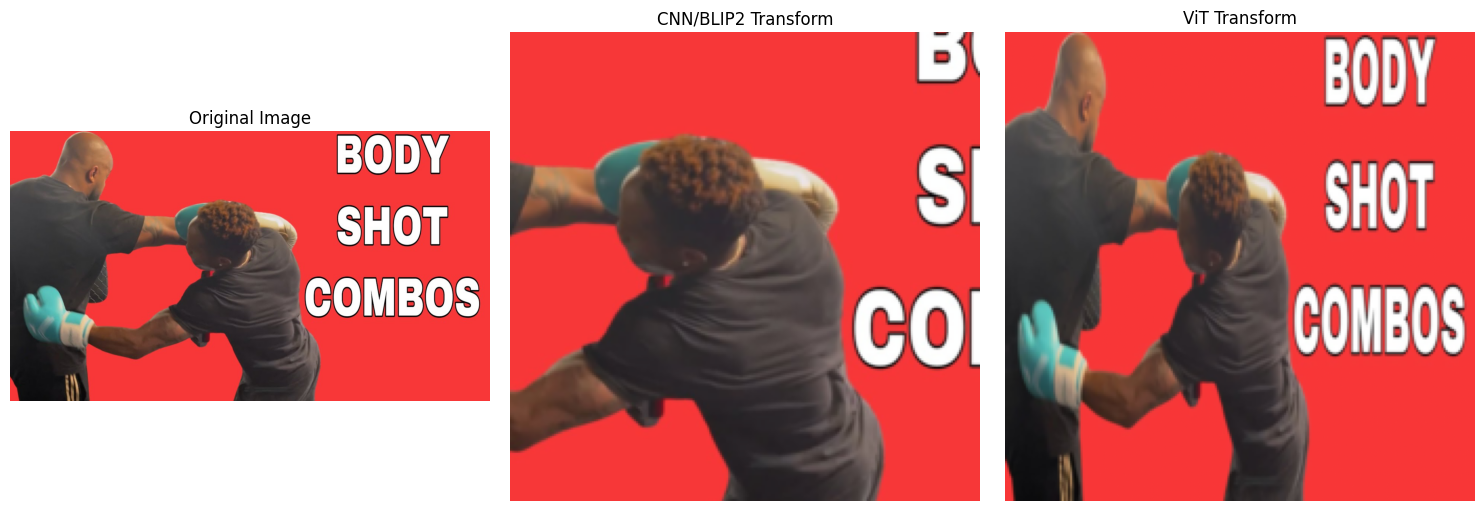

CNN/BLIP2 Transform details:
- Resize to 256x256
- Center crop to 224x224
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (ImageNet stats)

ViT Transform details:
- Resize to 224x224
- Normalize with mean=0.5, std=0.5 (for all channels)
- Split image into 16x16 patches (not visible in the transformation)

Summary of input/output shapes for /content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/train/images/boxing_102.jpg:
Original image: 1280x720
CNN/BLIP2 output: 224x224
ViT output: 224x224




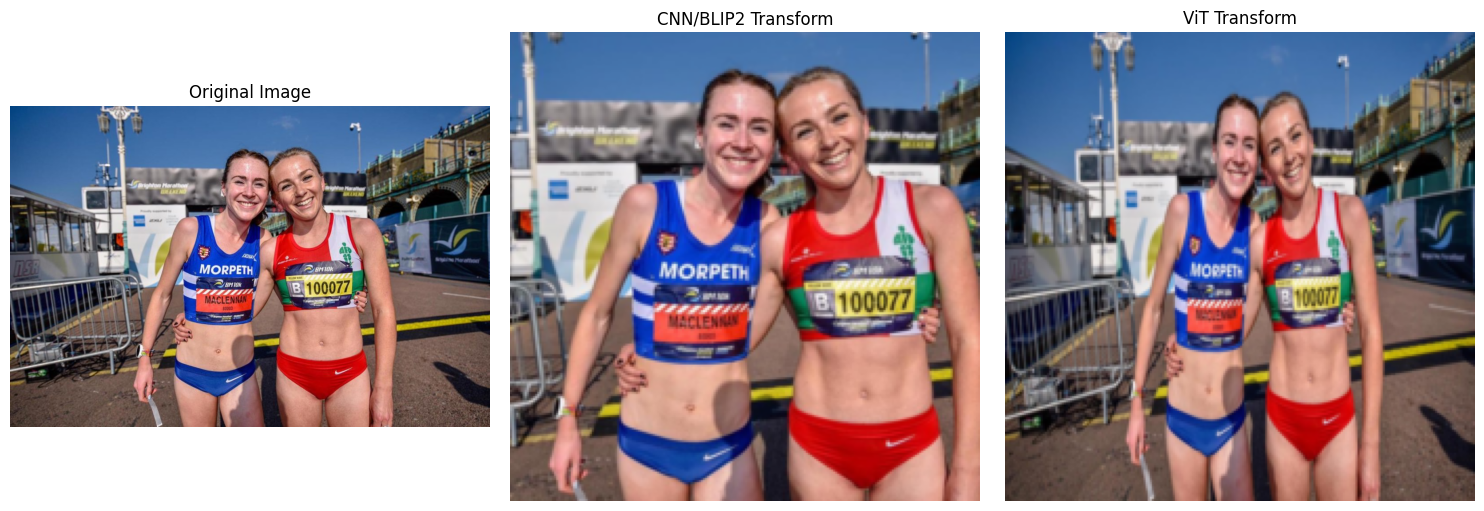

CNN/BLIP2 Transform details:
- Resize to 256x256
- Center crop to 224x224
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (ImageNet stats)

ViT Transform details:
- Resize to 224x224
- Normalize with mean=0.5, std=0.5 (for all channels)
- Split image into 16x16 patches (not visible in the transformation)

Summary of input/output shapes for /content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/train/images/athletics_22.jpg:
Original image: 1079x720
CNN/BLIP2 output: 224x224
ViT output: 224x224




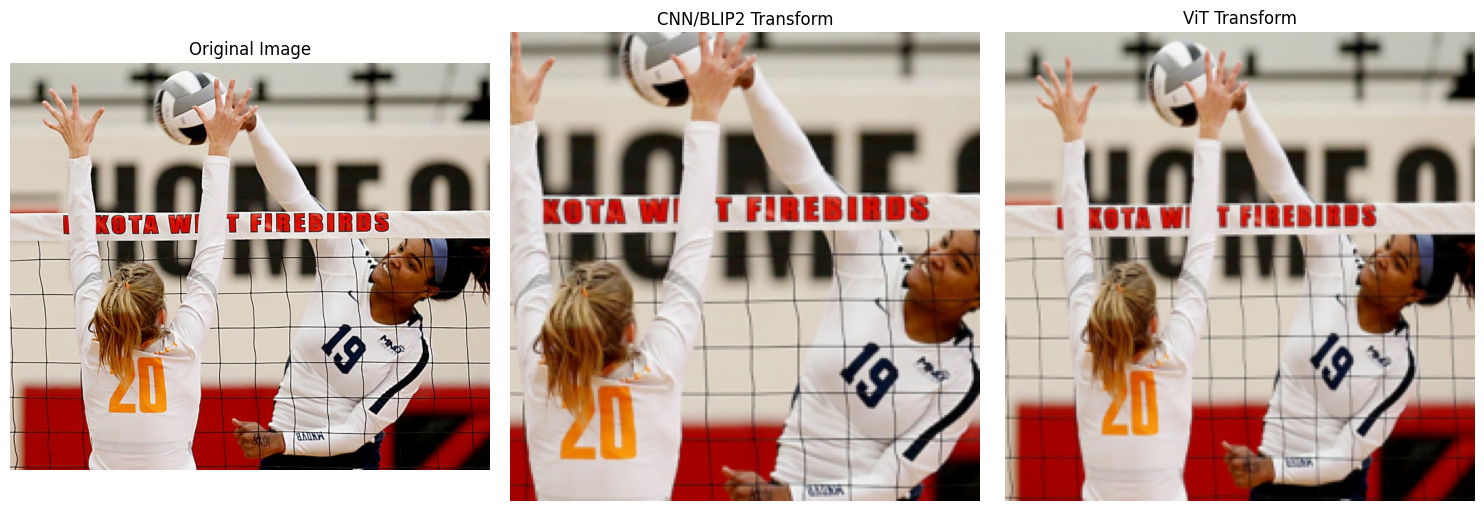

CNN/BLIP2 Transform details:
- Resize to 256x256
- Center crop to 224x224
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (ImageNet stats)

ViT Transform details:
- Resize to 224x224
- Normalize with mean=0.5, std=0.5 (for all channels)
- Split image into 16x16 patches (not visible in the transformation)

Summary of input/output shapes for /content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/train/images/volleyball_67.jpg:
Original image: 700x594
CNN/BLIP2 output: 224x224
ViT output: 224x224




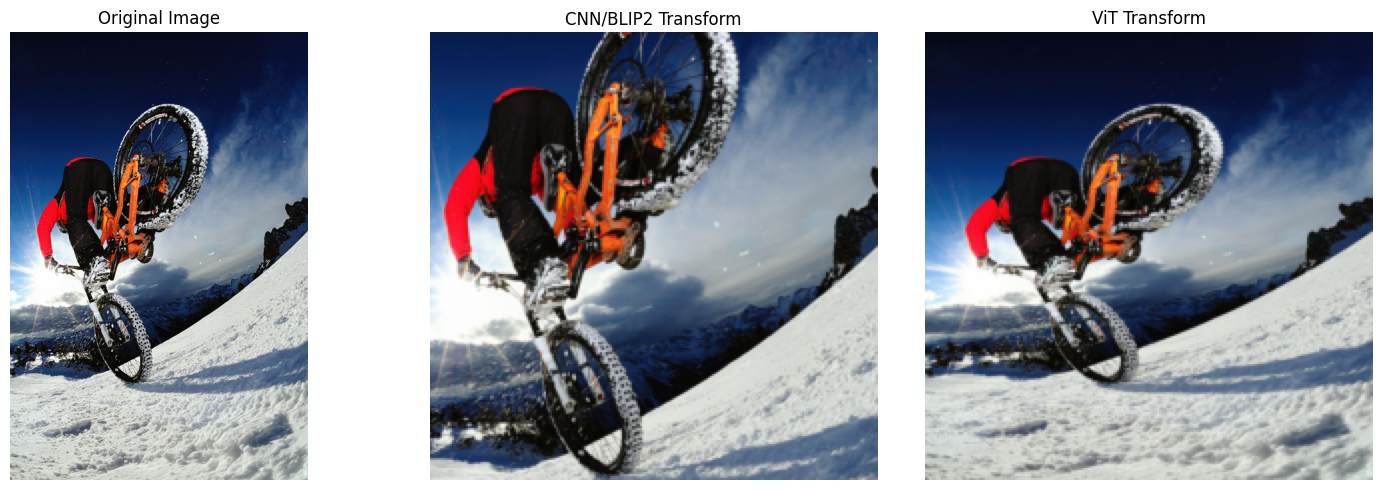

CNN/BLIP2 Transform details:
- Resize to 256x256
- Center crop to 224x224
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (ImageNet stats)

ViT Transform details:
- Resize to 224x224
- Normalize with mean=0.5, std=0.5 (for all channels)
- Split image into 16x16 patches (not visible in the transformation)

Summary of input/output shapes for /content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/train/images/cycling_13.jpg:
Original image: 465x700
CNN/BLIP2 output: 224x224
ViT output: 224x224




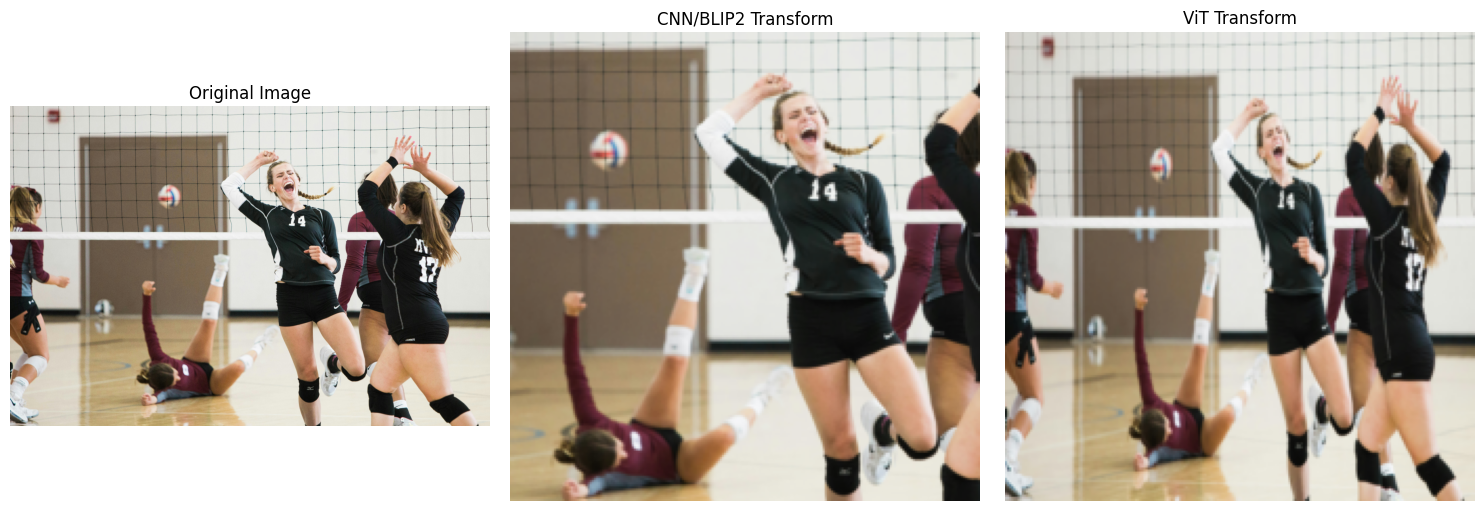

CNN/BLIP2 Transform details:
- Resize to 256x256
- Center crop to 224x224
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (ImageNet stats)

ViT Transform details:
- Resize to 224x224
- Normalize with mean=0.5, std=0.5 (for all channels)
- Split image into 16x16 patches (not visible in the transformation)

Summary of input/output shapes for /content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/train/images/volleyball_44.jpg:
Original image: 4387x2925
CNN/BLIP2 output: 224x224
ViT output: 224x224




In [14]:
# Random lấy 5 ảnh từ tập dữ liệu ảnh train
path = '/content/drive/MyDrive/TextMining-CapyData/Code/Preprocessing/train/images'
image_filenames = os.listdir(path)
random.seed(42)  # Để tái tạo kết quả
random_images = random.sample(image_filenames, 5)
image_paths = [os.path.join(path, img) for img in random_images]

# Hiển thị ảnh và thông tin transformation
for image_path in image_paths:
    shapes = show_transformations(image_path)
    print(f"\nSummary of input/output shapes for {image_path}:")
    print(f"Original image: {shapes['original_shape'][0]}x{shapes['original_shape'][1]}")
    print(f"CNN/BLIP2 output: {shapes['cnn_blip2_shape'][0]}x{shapes['cnn_blip2_shape'][1]}")
    print(f"ViT output: {shapes['vit_shape'][0]}x{shapes['vit_shape'][1]}")
    print("\n" + "="*50 + "\n")

## ✂️ Split train/val/test

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import re

In [2]:
captions_path = "../data/processed_captions.txt"
image_path = "../data/raw_images/"
output_path = "../data/ic_dataset/"
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_path, split, "images"), exist_ok=True)

sports = [
    "Soccer", "Volleyball", "Baseball", "Tennis", "Basketball",
    "Badminton", "Swimming", "Surfing", "Archery", "Athletics",
    "Equestrianism", "Boxing", "Golf", "Skiing", "Cycling"
]

In [3]:
# Đọc tất cả các captions
captions = []
with open(captions_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            parts = line.strip().split('\t')
            if len(parts) == 2:
                image_name, caption_text = parts
                captions.append((image_name, caption_text))

# Tạo dictionary để lưu thông tin về ảnh và captions
image_to_captions = defaultdict(list)
for image_name, caption_text in captions:
    image_to_captions[image_name].append(caption_text)

# Phân loại ảnh theo các môn thể thao
sport_to_images = defaultdict(list)
for image_name in image_to_captions.keys():
    for sport in sports:
        if image_name.lower().startswith(sport.lower()):
            sport_to_images[sport].append(image_name)
            break

In [4]:
# Đếm số ảnh và captions cho mỗi môn thể thao
sport_counts = {}
sport_caption_counts = {}
for sport in sports:
    sport_images = sport_to_images[sport]
    num_images = len(sport_images)
    num_captions = sum(len(image_to_captions[img]) for img in sport_images)
    sport_counts[sport] = num_images
    sport_caption_counts[sport] = num_captions
    
    if num_images > 0:
        avg_captions = num_captions / num_images
    else:
        avg_captions = 0
    
    print(f"Môn {sport}: {num_images} ảnh, {num_captions} captions, trung bình {avg_captions:.2f} captions/ảnh")

Môn Soccer: 148 ảnh, 740 captions, trung bình 5.00 captions/ảnh
Môn Volleyball: 110 ảnh, 550 captions, trung bình 5.00 captions/ảnh
Môn Baseball: 113 ảnh, 565 captions, trung bình 5.00 captions/ảnh
Môn Tennis: 136 ảnh, 680 captions, trung bình 5.00 captions/ảnh
Môn Basketball: 127 ảnh, 635 captions, trung bình 5.00 captions/ảnh
Môn Badminton: 100 ảnh, 500 captions, trung bình 5.00 captions/ảnh
Môn Swimming: 113 ảnh, 565 captions, trung bình 5.00 captions/ảnh
Môn Surfing: 114 ảnh, 570 captions, trung bình 5.00 captions/ảnh
Môn Archery: 131 ảnh, 655 captions, trung bình 5.00 captions/ảnh
Môn Athletics: 87 ảnh, 435 captions, trung bình 5.00 captions/ảnh
Môn Equestrianism: 142 ảnh, 710 captions, trung bình 5.00 captions/ảnh
Môn Boxing: 117 ảnh, 585 captions, trung bình 5.00 captions/ảnh
Môn Golf: 128 ảnh, 640 captions, trung bình 5.00 captions/ảnh
Môn Skiing: 114 ảnh, 570 captions, trung bình 5.00 captions/ảnh
Môn Cycling: 124 ảnh, 620 captions, trung bình 5.00 captions/ảnh


In [5]:
# Chia dữ liệu theo stratified
train_images = {}
val_images = {}
test_images = {}

for sport in sports:
    images = sport_to_images[sport]
    if not images:
        train_images[sport] = []
        val_images[sport] = []
        test_images[sport] = []
        continue
        
    # Chia tập train và tập còn lại (val+test)
    train_imgs, temp_imgs = train_test_split(images, train_size=0.7, random_state=42)
    # Chia tập còn lại thành val và test
    val_imgs, test_imgs = train_test_split(temp_imgs, train_size=0.5, random_state=42)
    
    train_images[sport] = train_imgs
    val_images[sport] = val_imgs
    test_images[sport] = test_imgs

# Kiểm tra kết quả chia
print("\nSplit images successfully. (train/val/test)")
for sport in sports:
    print(f"{sport}: {len(train_images[sport])}/{len(val_images[sport])}/{len(test_images[sport])}")


Split images successfully. (train/val/test)
Soccer: 103/22/23
Volleyball: 77/16/17
Baseball: 79/17/17
Tennis: 95/20/21
Basketball: 88/19/20
Badminton: 70/15/15
Swimming: 79/17/17
Surfing: 79/17/18
Archery: 91/20/20
Athletics: 60/13/14
Equestrianism: 99/21/22
Boxing: 81/18/18
Golf: 89/19/20
Skiing: 79/17/18
Cycling: 86/19/19


In [6]:
# Tạo dictionary ánh xạ ảnh vào tập dữ liệu (train, val, test)
image_to_split = {}
for sport in sports:
    for img in train_images[sport]:
        image_to_split[img] = 'train'
    for img in val_images[sport]:
        image_to_split[img] = 'val'
    for img in test_images[sport]:
        image_to_split[img] = 'test'

# Đếm số lượng captions trong mỗi tập
train_captions_count = defaultdict(int)
val_captions_count = defaultdict(int)
test_captions_count = defaultdict(int)

for image_name, captions_list in image_to_captions.items():
    split = image_to_split.get(image_name)
    if not split:  # Nếu ảnh không thuộc bất kỳ môn thể thao nào
        continue
        
    # Tìm môn thể thao của ảnh
    sport = None
    for s in sports:
        if image_name.lower().startswith(s.lower()):
            sport = s
            break
            
    if sport:
        num_captions = len(captions_list)
        if split == 'train':
            train_captions_count[sport] += num_captions
        elif split == 'val':
            val_captions_count[sport] += num_captions
        elif split == 'test':
            test_captions_count[sport] += num_captions

print("\nSplit captions successfully. (train/val/test)")
for sport in sports:
    print(f"{sport}: {train_captions_count[sport]}/{val_captions_count[sport]}/{test_captions_count[sport]}")


Split captions successfully. (train/val/test)
Soccer: 515/110/115
Volleyball: 385/80/85
Baseball: 395/85/85
Tennis: 475/100/105
Basketball: 440/95/100
Badminton: 350/75/75
Swimming: 395/85/85
Surfing: 395/85/90
Archery: 455/100/100
Athletics: 300/65/70
Equestrianism: 495/105/110
Boxing: 405/90/90
Golf: 445/95/100
Skiing: 395/85/90
Cycling: 430/95/95


In [7]:
# Đổi tên ảnh và sao chép vào thư mục đích
image_counter = 100000000000  # Bắt đầu đánh số từ 100000000000
new_image_names = {}  # Lưu ánh xạ giữa tên cũ và tên mới

# Hàm để sao chép và đổi tên ảnh
def copy_and_rename_images():
    global image_counter
    
    # Tạo danh sách tất cả các file ảnh có trong thư mục
    available_images = []
    for root, _, files in os.walk(image_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                available_images.append(file)
    
    for image_name in image_to_split.keys():
        # Tìm file ảnh tương ứng trong thư mục
        found = False
        for img_file in available_images:
            if img_file == image_name:
                found = True
                src_path = os.path.join(image_path, img_file)
                break
                
        if not found:  # Nếu không tìm thấy file ảnh
            print(f"Cảnh báo: Không tìm thấy ảnh {image_name}")
            continue
            
        # Lấy phần mở rộng của file
        _, ext = os.path.splitext(image_name)
        
        # Tạo tên mới
        new_name = f"{image_counter}{ext}"
        image_counter += 1
        
        # Lưu ánh xạ
        new_image_names[image_name] = new_name
        
        # Sao chép ảnh vào thư mục tương ứng
        split = image_to_split[image_name]
        dst_path = os.path.join(output_path, split, "images", new_name)
        shutil.copy2(src_path, dst_path)

# Tạo file captions.txt cho từng tập
def create_caption_files():
    for split in ['train', 'val', 'test']:
        with open(os.path.join(output_path, split, "captions.txt"), 'w', encoding='utf-8') as f:
            for image_name, captions_list in image_to_captions.items():
                if image_to_split.get(image_name) == split:
                    new_name = new_image_names.get(image_name)
                    if new_name:
                        for caption in captions_list:
                            f.write(f"{new_name}\t{caption}\n")

# Thực hiện sao chép và đổi tên ảnh
copy_and_rename_images()

# Tạo file captions.txt
create_caption_files()

print("\nĐã hoàn thành việc chia dữ liệu và sao chép vào thư mục đích.")
print(f"Dữ liệu đã được lưu vào {output_path}")


Đã hoàn thành việc chia dữ liệu và sao chép vào thư mục đích.
Dữ liệu đã được lưu vào ../data/ic_dataset/


In [8]:
# labeling
def vietnamese_labels(text):
    map = {
        'soccer': 'bóng_đá',
        'volleyball': 'bóng_chuyền',
        'baseball': 'bóng_chày',
        'tennis': 'quần_vợt',
        'basketball': 'bóng_rổ',
        'badminton': 'cầu_lông',
        'swimming': 'bơi_lội',
        'surfing': 'lướt_sóng',
        'archery': 'bắn cung',
        'athletics': 'điền_kinh',
        'equestrianism': 'cưỡi ngựa',
        'boxing': 'boxing',
        'golf': 'golf',
        'skiing': 'trượt_tuyết',
        'cycling': 'đạp xe'
    }
    return map.get(text.lower(), text.lower())
        
def create_labels_file(split, image_to_split, output_path):
    labels = []
    for image_name, split_type in image_to_split.items():
        if split_type == split:
            new_image_name = new_image_names.get(image_name)
            if not new_image_name:
                print(f"Cảnh báo: Không tìm thấy tên mới cho ảnh {image_name}")
                continue

            label = re.sub(r'(_\d+)?\.jpg$', '', image_name).split('_')[0]
            label = vietnamese_labels(label)
            labels.append(f"{new_image_name},{label}")

    with open(os.path.join(output_path, f"labels.txt"), 'w', encoding='utf-8') as f:
        f.write("\n".join(labels))

# Tạo labels.txt cho từng tập train/val/test
output_path = "../data/ic_dataset/"
create_labels_file('train', image_to_split, output_path + 'train')
create_labels_file('val', image_to_split, output_path + 'val')
create_labels_file('test', image_to_split, output_path + 'test')

## 📚 Build Vocabulary

In [14]:
import os
import json
import pickle

In [15]:
def read_captions(file_path):
    captions = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Tách đường dẫn ảnh và caption
            parts = line.strip().split('\t')
            if len(parts) == 2:
                image_path = parts[0]
                caption = parts[1]
                
                captions.append({
                    'image_path': image_path,
                    'caption': caption
                })
    
    return pd.DataFrame(captions)

def tokenize_caption(caption_df):
    tokenized_captions = []
    
    for idx, row in caption_df.iterrows():
        caption = row['caption']
        
        # Tách caption thành các token (dựa vào khoảng trắng)
        tokens = caption.strip().split()
        
        # Tạo lại caption từ tokens
        tokenized_caption = ' '.join(tokens)
        
        tokenized_captions.append(tokenized_caption)
    
    caption_df['tokenized_caption'] = tokenized_captions
    return caption_df

def build_vocabulary(caption_df, min_word_freq=5):
    # Đếm tần suất xuất hiện của các từ
    word_counts = Counter()
    
    for caption in caption_df['tokenized_caption']:
        words = caption.split()
        word_counts.update(words)
    
    # Thêm token đặc biệt
    vocab = {
        '<pad>': 0,  # Padding
        '<unk>': 1,  # Unknown
        '<s>': 2,  # Bắt đầu câu 
        '</s>': 3  # Kết thúc câu
    }
    
    # Thêm các từ có tần suất xuất hiện lớn hơn ngưỡng
    idx = len(vocab)
    for word, count in word_counts.items():
        if count >= min_word_freq and word not in vocab:
            vocab[word] = idx
            idx += 1
    
    # Tạo mapping ngược từ index sang từ
    idx_to_word = {idx: word for word, idx in vocab.items()}
    
    print(f"Vocabulary size: {len(vocab)}")
    return vocab, idx_to_word, word_counts

def save_vocabulary(vocab, idx_to_word, word_counts, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Lưu vocab
    with open(os.path.join(save_path, 'vocab.json'), 'w', encoding='utf-8') as f:
        json.dump(vocab, f, ensure_ascii=False, indent=2)
    
    # Lưu idx_to_word
    with open(os.path.join(save_path, 'idx_to_word.json'), 'w', encoding='utf-8') as f:
        json.dump(idx_to_word, f, ensure_ascii=False, indent=2)
    
    # Lưu word_counts
    with open(os.path.join(save_path, 'word_counts.pkl'), 'wb') as f:
        pickle.dump(dict(word_counts), f)
    
    # Lưu danh sách các từ theo tần suất xuất hiện (để phân tích)
    word_freq_df = pd.DataFrame({
        'word': list(word_counts.keys()),
        'frequency': list(word_counts.values())
    }).sort_values('frequency', ascending=False)
    
    word_freq_df.to_csv(os.path.join(save_path, 'word_frequencies.csv'), 
                         index=False, encoding='utf-8')
    
    print(f"Vocabulary saved to {save_path}")

def encode_captions(caption_df, vocab):
    encoded_captions = []
    
    for caption in caption_df['tokenized_caption']:
        words = caption.split()
        # Chuyển mỗi từ thành index tương ứng trong vocab
        indices = [vocab.get(word, vocab['<unk>']) for word in words]
        encoded_captions.append(indices)
    
    caption_df['encoded_caption'] = encoded_captions
    return caption_df

def create_image_caption_mapping(caption_df):
    image_to_captions = {}
    
    for idx, row in caption_df.iterrows():
        image_path = row['image_path']  # Thay image_filename bằng image_path
        caption = row['tokenized_caption']
        encoded_caption = row['encoded_caption']
        
        if image_path not in image_to_captions:
            image_to_captions[image_path] = []
        
        image_to_captions[image_path].append({
            'caption': caption,
            'encoded_caption': encoded_caption
        })
    
    return image_to_captions

def analyze_vocabulary(vocab, word_counts, caption_df):
    print(f"Tổng số từ trong vocabulary: {len(vocab)}")
    
    # Phân tích độ dài caption
    caption_lengths = [len(caption.split()) for caption in caption_df['tokenized_caption']]
    max_length = max(caption_lengths)
    min_length = min(caption_lengths)
    avg_length = sum(caption_lengths) / len(caption_lengths)
    
    print(f"Độ dài caption: Min = {min_length}, Max = {max_length}, Trung bình = {avg_length:.2f}")
    
    # Top 20 từ phổ biến nhất (loại bỏ <s> và <\s>)
    most_common = [item for item in word_counts.most_common(22) if item[0] not in ['<s>', '<\s>']][:20]
    print("Top 20 từ phổ biến nhất:")
    for word, count in most_common:
        print(f"  {word}: {count}")
    
    # Số lượng từ hiếm (xuất hiện ít hơn ngưỡng)
    rare_words = sum(1 for word, count in word_counts.items() if count < 5)
    print(f"Số lượng từ hiếm (xuất hiện < 5 lần): {rare_words}")

In [17]:
# Build vocabulary for US-Capydata-ViSportIC
print("Building vocabulary for US-Capydata-ViSportIC...")
train_caption_us = "../data/ic_dataset/train/captions.txt"
val_caption_us = "../data/ic_dataset/val/captions.txt"

df_train_us = read_captions(train_caption_us)
df_val_us = read_captions(val_caption_us)
df_us = pd.concat([df_train_us, df_val_us])

# Tokenize captions
df_us = tokenize_caption(df_us.copy())

# Build vocabulary
vocab_us, idx_to_word_us, word_counts_us = build_vocabulary(df_us, min_word_freq=5)

# Save vocabulary
save_path_us = "../data/ic_dataset/vocab"
os.makedirs(save_path_us, exist_ok=True)
save_vocabulary(vocab_us, idx_to_word_us, word_counts_us, save_path_us)

# Save mapping
df_us = encode_captions(df_us, vocab_us)

image_caption_mapping_us = create_image_caption_mapping(df_us)
with open(os.path.join(save_path_us, 'image_caption_mapping.pkl'), 'wb') as f:
    pickle.dump(image_caption_mapping_us, f)

analyze_vocabulary(vocab_us, word_counts_us, df_us)

Building vocabulary for US-Capydata-ViSportIC...
Vocabulary size: 1137
Vocabulary saved to ../data/ic_dataset/vocab
Tổng số từ trong vocabulary: 1137
Độ dài caption: Min = 8, Max = 20, Trung bình = 12.37
Top 20 từ phổ biến nhất:
  vận_động_viên: 3456
  trong: 2478
  cú: 1859
  đang: 1761
  thể_hiện: 1749
  trên: 1607
  với: 1370
  bóng: 1352
  người: 1326
  sự: 1273
  và: 1198
  mạnh_mẽ: 1015
  sân: 983
  chuẩn_bị: 971
  một: 945
  cho: 927
  trang_phục: 858
  của: 854
  tư_thế: 833
  cầu_thủ: 782
Số lượng từ hiếm (xuất hiện < 5 lần): 1537
